# Music Genre Classification

Wan Yee Ki 1155143499, AIST2010 Project 

Remark:
1. librosa.load is dfferent from scipy.io.wavfile.read
    - librosa.load() normalizes the data (betwenn 1 and -1)
    - scipy.io.wavfile.read() does not normalize the data
2. This notebook has been tested on Windows 10 64-bit only

PC Environment:
1. Intel i7-9750H
2. NVIDIA GTX 1660 TI

Python Environment (Python 3.9.6):
- audiomentation==0.19.1
- tqdm==4.62.2
- tensorflow==2.5.0
- spotipy==2.19.0
- seaborn==0.11.2
- scipy==1.7.1
- scikit-learn==1.0
- pandas==1.3.3
- pedalboard==0.3.8
- numpy==1.20.3
- multiprocess==0.70.12.2
- matplotlib==3.4.2
- librosa==0.8.1
- youtube_dl==2021.6.6

Reference:
1. https://klyshko.github.io/teaching/2019-02-22-teaching
2. Building Machine Learning Systems
3. Tensorflow Quick Start Guide 

In [2]:
import soundfile as sf
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import multiprocess as mp
import urllib.request
import librosa.display
import librosa
import tarfile
import os
import sys
import gc
import scipy
import scipy.io.wavfile
from tqdm import tqdm
import multiprocess as mp
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn import preprocessing


plt.style.use('seaborn')

## Constant

In [3]:
DATA_DIR = "sound_data" # folder for storing data
DATA_URL = 'http://opihi.cs.uvic.ca/sound/genres.tar.gz' # url for downloading data
SOX_PATH = r'C:\Program Files (x86)\sox-14-4-2' # path to sox (download from https://sourceforge.net/projects/sox/)
SOX = SOX_PATH + '\sox.exe' 
FFT_TOTAL = 2000 # number of frequencies to be extracted while performing FFT

## Data Preparation

### Downloading data

In [3]:
# create data folder if not exist
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

In [4]:
# download GTZAN dataset if not exist
# It takes around 45 minutes to download
# Total size: 1.2GB
if not os.path.exists(f"{DATA_DIR}/genres.tar.gz"):
    urllib.request.urlretrieve(DATA_URL, f"{DATA_DIR}/genres.tar.gz")

### Extracting files

In [5]:
# extract the downloaded file
if not os.path.exists(f"{DATA_DIR}/genres"):
    with tarfile.open(f"{DATA_DIR}/genres.tar.gz") as f:
        f.extractall(f"{DATA_DIR}")

In [6]:
# list of all genres available for classification
GENRES = list(os.walk(f"{DATA_DIR}/genres"))[0][1]
print(GENRES)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


## Utils
At the very begining, I think it would be possible to retrieve song metadata using Spotify API.

However, I soon found that most of the songs in Spotify are missing the field "genre"

The code is kept here for reference

Reference:

1. https://github.com/christianlomboy/MIR-Genre-Predictor

### Fetch song metadata from Spotify
You may generate your own client id and client secret in the following website:

https://developer.spotify.com/dashboard/login

In [7]:
import spotipy
SPOTIFY_CLIENT_ID = 
SPOTIFY_CLIENT_SECRET = 

In [8]:
# Create Spotify Search Engine object
def get_spotify_engine(client_id, client_secret):
    return spotipy.Spotify(auth_manager=spotipy.oauth2.SpotifyClientCredentials(client_id=client_id, client_secret=client_secret))

# fetch song information from spotify
def fetch_song_info(sp, song_name):
    results = sp.search(q=song_name, type='track')
    items = results['tracks']['items']
    
    album_genre = sp.album(items[0]["album"]["external_urls"]["spotify"])['genres']
    artist_genre = sp.artist(items[0]["artists"][0]["external_urls"]["spotify"])['genres']
    print(f"Song Name: {items[0]['name']}")
    print(f"Song Artist: {items[0]['artists'][0]['name']}")
    print(f"Song Album: {items[0]['album']['name']}")
    print(f"Album Genre: {album_genre}")
    print(f"Artist Genre: {artist_genre}")
    print(f"Track id: {items[0]['id']}")
    print("-- -- -- -- -- -- --")
    
    features = sp.audio_features(tracks = items[0]['id'])
    print(f"Danceability: {features[0]['danceability']}")
    print(f"Energy: {features[0]['energy']}")
    print(f"Key: {features[0]['key']}")
    print(f"Lounness: {features[0]['loudness']}")
    print(f"Mode: {features[0]['mode']}")
    print(f"Speechiness: {features[0]['speechiness']}")
    print(f"Acousticness: {features[0]['acousticness']}")
    print(f"Instrumentalness: {features[0]['instrumentalness']}")
    print(f"Liveness: {features[0]['liveness']}")
    print(f"Valence: {features[0]['valence']}")
    print(f"Tempo: {features[0]['tempo']}")
    print(f"Duration: {features[0]['duration_ms']//1000}s")
    print(f"Time signature: {features[0]['time_signature']}")

In [9]:
sp = get_spotify_engine(SPOTIFY_CLIENT_ID, SPOTIFY_CLIENT_SECRET)

In [10]:
fetch_song_info(sp, 'River flows to you')

Song Name: River Flows In You
Song Artist: Yiruma
Song Album: Yiruma 2nd Album 'First Love' (The Original & the Very First Recording)
Album Genre: []
Artist Genre: ['korean instrumental', 'neo-classical', 'new age piano']
Track id: 2agBDIr9MYDUducQPC1sFU
-- -- -- -- -- -- --
Danceability: 0.315
Energy: 0.22
Key: 9
Lounness: -21.343
Mode: 1
Speechiness: 0.0514
Acousticness: 0.987
Instrumentalness: 0.943
Liveness: 0.0802
Valence: 0.116
Tempo: 145.195
Duration: 188s
Time signature: 4


### Downloading Music from Youtube

In [11]:
# search music from youtube, download it and conert to wav
import youtube_dl
def download_youtube_audio(link, output_dir):
    ytdl_format_options = {
    'format': 'bestaudio/best',
    'outtmpl': f'{output_dir}/%(title)s.%(ext)s',
    'noplaylist': True,
    'nocheckcertificate': True,
    'ignoreerrors': False,
    'logtostderr': False,
    'quiet': False,
    'no_warnings': False,
    'default_search': 'auto',
    'source_address': '0.0.0.0',
    'postprocessors': [{
        'key': 'FFmpegExtractAudio',
        'preferredcodec': 'wav'
    }]
   }
    
    with youtube_dl.YoutubeDL(ytdl_format_options) as ydl:
        info = ydl.extract_info(link, download=True)

In [12]:
download_youtube_audio('River Flows in You', f'{DATA_DIR}/youtube_audio')

[download] Downloading playlist: River Flows in You
[youtube:search] query "River Flows in You": Downloading page 1
[youtube:search] playlist River Flows in You: Downloading 1 videos
[download] Downloading video 1 of 1
[youtube] 7maJOI3QMu0: Downloading webpage
[youtube] Downloading just video 7maJOI3QMu0 because of --no-playlist
[youtube] 7maJOI3QMu0: Downloading player ad2aeb77
[download] Destination: sound_data\youtube_audio\Yiruma, (이루마) - River Flows in You.webm
[download] 100% of 3.84MiB in 00:48                 
[ffmpeg] Destination: sound_data\youtube_audio\Yiruma, (이루마) - River Flows in You.wav
Deleting original file sound_data\youtube_audio\Yiruma, (이루마) - River Flows in You.webm (pass -k to keep)
[download] Finished downloading playlist: River Flows in You


## Visulaization

### 1. Creating plots: Waveform, Spectrum, Spectrogram

In [13]:
def plot_spectrum(file_name, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1)
        
    X, sample_rate = librosa.load(file_name, sr=22050, mono=True)
    spectrum = np.fft.fft(X)
    freq = np.fft.fftfreq(len(X), 1.0 / sample_rate)
    
    ax.plot(freq, abs(spectrum), linewidth=2)
    ax.set(title='Spectrum', xlabel='frequency [Hz]', xlim=(0,11025))
    
    return ax

def plot_spectrogram(file_name, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1)
    X, sample_rate = librosa.load(file_name, sr=22050, mono=True)
    D = librosa.stft(X)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    librosa.display.specshow(S_db, ax=ax, x_axis='time', y_axis='linear')
    ax.set(title='Spectrogram', xlabel='Time [s]')

def plot_waveform(file_name, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1)
    x, sr = librosa.load(file_name, sr=22050, mono=True)
    librosa.display.waveplot(x, ax=ax)
    ax.set(title='Waveform', xlabel='Time [s]')

In [14]:
# Creating a sine wave audio for testing purpose
!"{SOX}" --null -r 22050 sine_a.wav synth 1 sine 1000

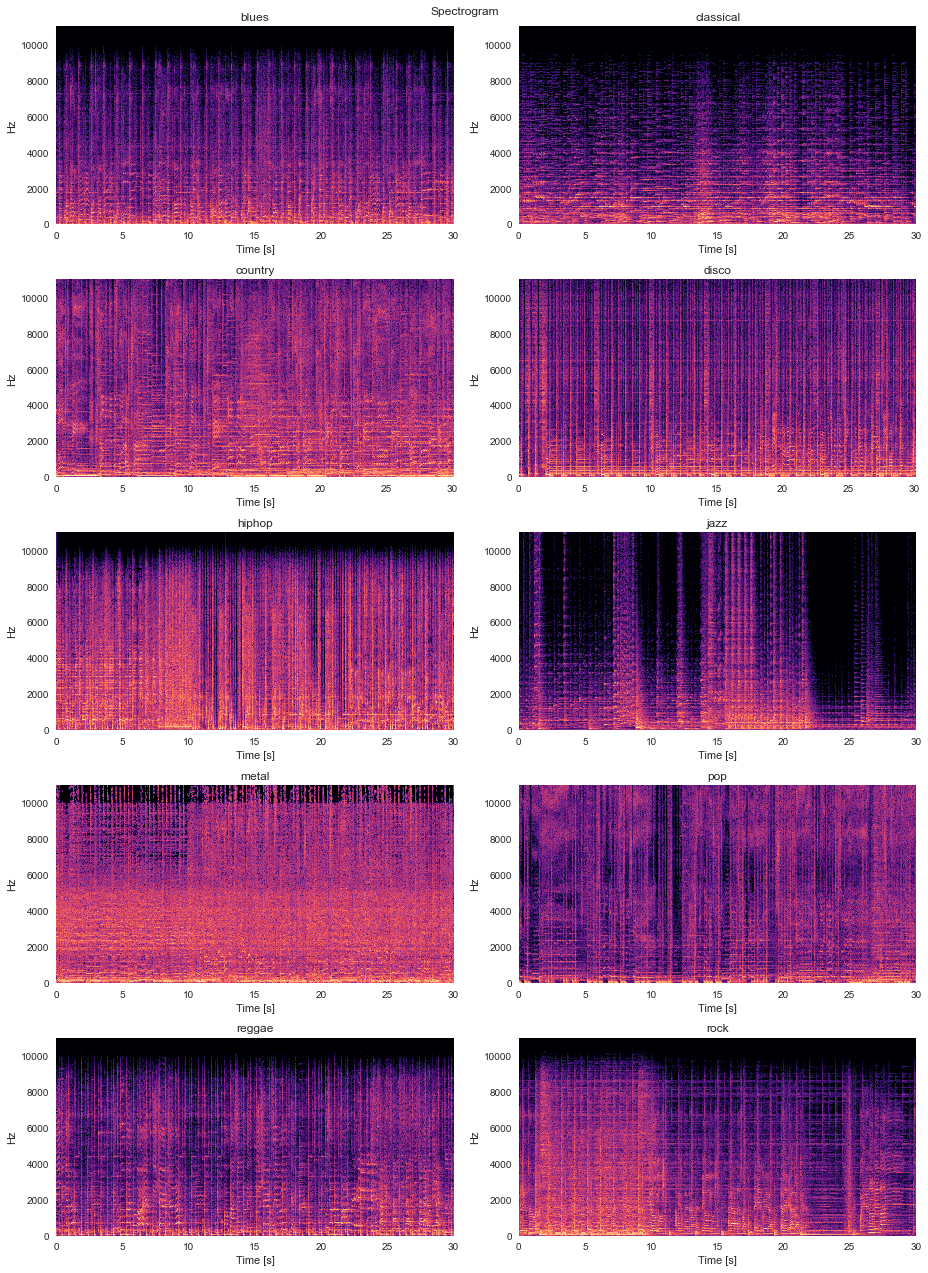

In [15]:
# Creating spectrogram among all genres
fig, ax = plt.subplots(5, 2, figsize=(13,18))
fig.suptitle('Spectrogram')
fig.tight_layout(h_pad=5)
for i, g in enumerate(GENRES):
    plot_spectrogram(f'{DATA_DIR}/genres/{g}/{g}.00000.wav', ax[i//2, i%2])
    ax[i//2, i%2].set_title(g)
fig.tight_layout()

plt.show()

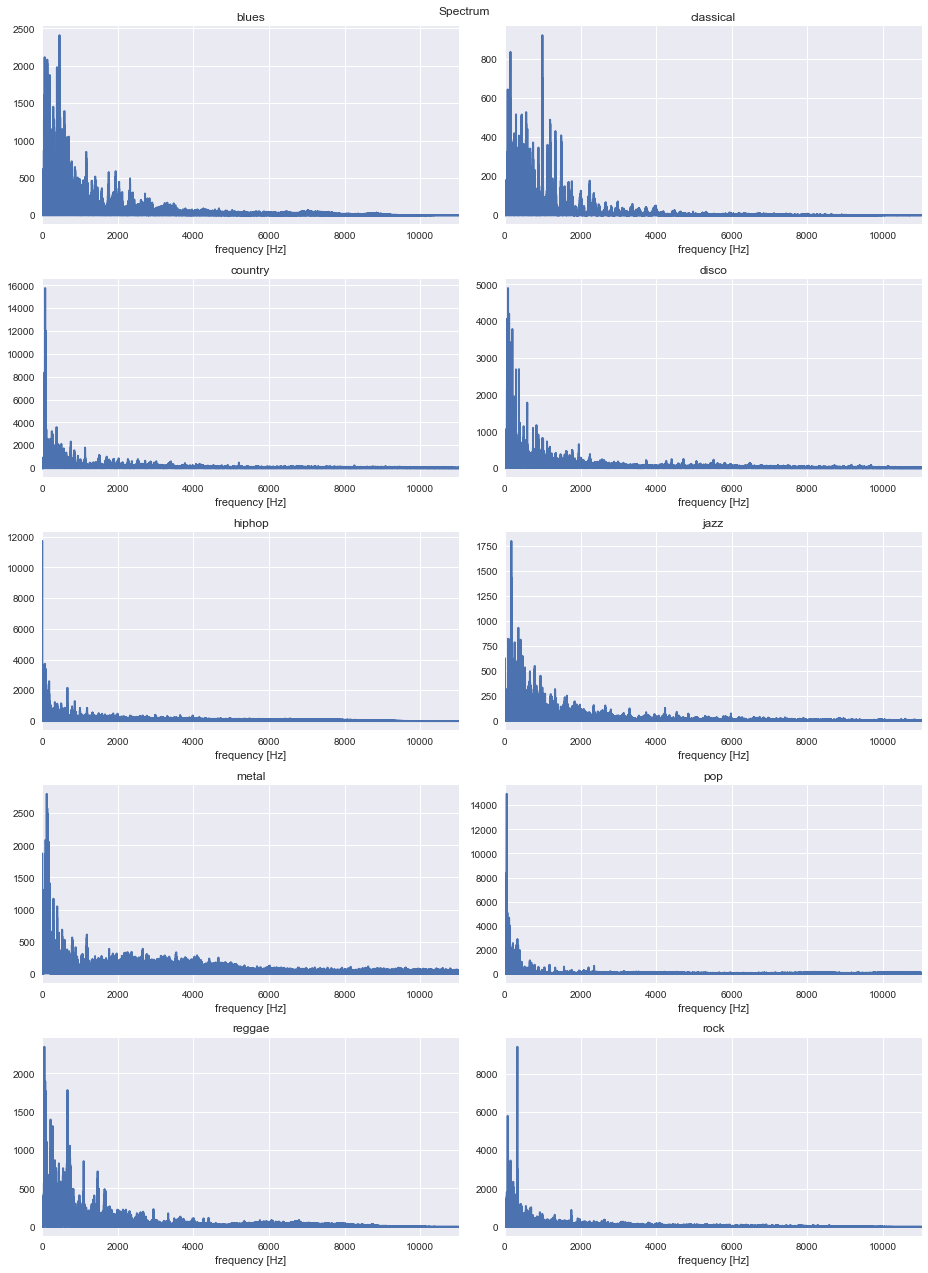

In [16]:
# Creating spectrum among all genres
fig, ax = plt.subplots(5, 2, figsize=(13,18))
fig.suptitle('Spectrum')
fig.tight_layout(h_pad=5)
for i, g in enumerate(GENRES):
    plot_spectrum(f'{DATA_DIR}/genres/{g}/{g}.00000.wav', ax[i//2, i%2])
    ax[i//2, i%2].set_title(g)
fig.tight_layout()

plt.show()

### 2. Confusion matrix

In [17]:
def result_visualise(y_true, y_pred, ytick=None):
    plt.clf()
    mat = confusion_matrix(y_true, y_pred)
    sns.heatmap(mat, annot=True, cmap='YlGnBu', yticklabels=ytick, xticklabels=ytick)
    plt.show()

In [18]:
# Generating data for testing purpose
y_true = np.random.randint(0, 10, 1000)
y_pred = np.random.randint(0, 10, 1000)

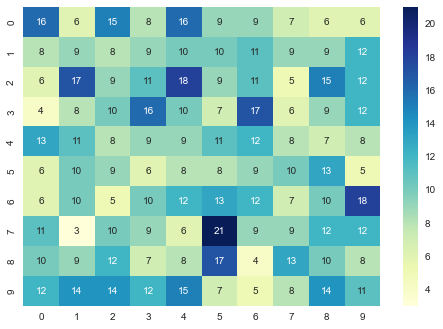

In [19]:
result_visualise(y_true, y_pred, [str(i) for i in range(10)])

## First Attempt

### Feature extraction
In the first attempt, I will extract the frequencies with the FFT_TOTAL highest magnitude

In [20]:
# Extract frequencies with highest amplitude
# Notice that the following code will use all of the CPU resources
if not os.path.exists(f'{DATA_DIR}/original_fft_max{FFT_TOTAL}.csv'):
    def produce_df(path, label, num):
        def convert_fft_csv(df, filename, path, label, num):
            sampFreq, sound = scipy.io.wavfile.read(path)
            signal = sound
            fft_spectrum = np.fft.rfft(signal)
            freq = np.fft.rfftfreq(signal.size, d=1./sampFreq)
            fft_spectrum_abs = np.abs(fft_spectrum)
            
            x = np.column_stack((np.round(freq, 1), np.round(fft_spectrum_abs)))
            data = np.array(sorted(x, key=lambda x: x[1], reverse=True)[:num])[:, 0]

            tmpdf = pd.DataFrame(data.reshape(1,-1), columns=[f"x_{i}" for i in range(num)]).assign(filename=filename).assign(label=label)
            return df.append(tmpdf, ignore_index=True)
        
        import pandas as pd, numpy as np, scipy.io.wavfile, os
        df = pd.DataFrame(columns=['filename', 'label']+[f"x_{i}" for i in range(num)], index=None)
        for file in os.listdir(path):
            exact_path = f"{path}/{file}"
            df = convert_fft_csv(df, file, exact_path, label, num)
        return df

    para = []     
    for g in GENRES:
        para.append((f"{DATA_DIR}/genres/{g}", g, FFT_TOTAL))

    pool = mp.Pool(mp.cpu_count())
    data = pool.starmap(produce_df, para)

In [21]:
# store the data as csv format under DATA_DIR
if not os.path.exists(f'{DATA_DIR}/original_fft_max{FFT_TOTAL}.csv'):
    df = pd.DataFrame(columns=['filename', 'label']+[f"x_{i}" for i in range(FFT_TOTAL)], index=None)
    for i in range(10):
        df = df.append(data[i], ignore_index=True)
        df.to_csv(f'{DATA_DIR}/original_fft_max{FFT_TOTAL}.csv')
    pool.terminate()

### Loading back data

In [22]:
def read_fft_csv(path):
    df = pd.read_csv(path, index_col=0)
    X = df.loc[:, 'x_0':]
    y = df.loc[:, 'label']
    return X, y
X, y = read_fft_csv(f'{DATA_DIR}/original_fft_max{FFT_TOTAL}.csv')

In [23]:
# replace genre name to number labelling
for idx, label in enumerate(GENRES):
    y = y.replace(label, idx)

### Classification
Here we start with simple model first

#### Seperate data into training set and testing set

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### 1. Logistic Regression

In [25]:
clf = LogisticRegression(max_iter=100000).fit(X_train, y_train)

In [26]:
print(f"Accuracy on training data: {clf.score(X_train, y_train)}")
print(f"Accuracy on testing data: {clf.score(X_test, y_test)}")

Accuracy on training data: 1.0
Accuracy on testing data: 0.12666666666666668


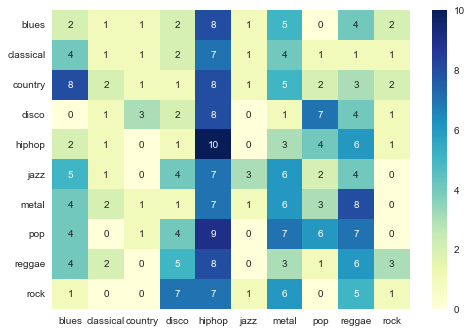

In [27]:
result_visualise(y_test, clf.predict(X_test), GENRES)

#### 2. Random Forest

In [28]:
clf = RandomForestClassifier(1000).fit(X_train, y_train)

In [29]:
print(f"Accuracy on training data: {clf.score(X_train, y_train)}")
print(f"Accuracy on training data: {clf.score(X_test, y_test)}")

Accuracy on training data: 1.0
Accuracy on training data: 0.3566666666666667


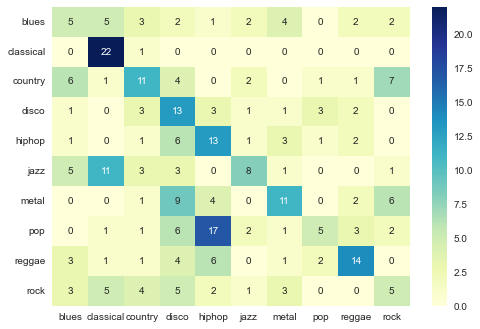

In [30]:
result_visualise(y_test, clf.predict(X_test), GENRES)

#### 3. Simple Neural Network

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train = tf.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = tf.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [32]:
batch_size = 16
epochs = 50

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(2000,1)))
model.add(tf.keras.layers.Dense(2048, activation='relu'))
model.add(tf.keras.layers.Dense(2048, activation='relu'))
model.add(tf.keras.layers.Dense(2048, activation='relu'))
model.add(tf.keras.layers.Dense(2048, activation='relu'))
model.add(tf.keras.layers.Dense(2048, activation='relu'))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

optimiser = tf.keras.optimizers.Adam()
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [33]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/50
44/44 [==============================] - 3s 12ms/step - loss: 85.0187 - accuracy: 0.1229
Epoch 2/50
44/44 [==============================] - 0s 9ms/step - loss: 2.3964 - accuracy: 0.1100
Epoch 3/50
44/44 [==============================] - 0s 8ms/step - loss: 2.3116 - accuracy: 0.1157
Epoch 4/50
44/44 [==============================] - 0s 8ms/step - loss: 2.3278 - accuracy: 0.1543
Epoch 5/50
44/44 [==============================] - 0s 8ms/step - loss: 2.3181 - accuracy: 0.1386
Epoch 6/50
44/44 [==============================] - 0s 8ms/step - loss: 2.1982 - accuracy: 0.1800
Epoch 7/50
44/44 [==============================] - 0s 8ms/step - loss: 2.2149 - accuracy: 0.1771
Epoch 8/50
44/44 [==============================] - 0s 8ms/step - loss: 2.1896 - accuracy: 0.1814
Epoch 9/50
44/44 [==============================] - 0s 8ms/step - loss: 2.2085 - accuracy: 0.1986
Epoch 10/50
44/44 [==============================] - 0s 8ms/step - loss: 2.4389 - accuracy: 0.2043
Epoch 11/50
44/44

In [34]:
model.evaluate(X_test, y_test)

10/10 [==============================] - 0s 13ms/step - loss: 2.4748 - accuracy: 0.1567


[2.47478985786438, 0.15666666626930237]

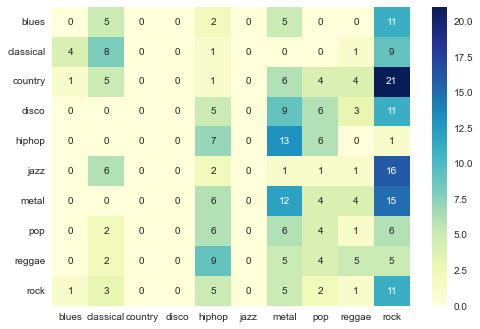

In [35]:
result_visualise(y_test, np.argmax(model.predict(X_test), axis=-1), GENRES)

#### 4. CNN

In [36]:
batch_size = 16
epochs = 50

model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Conv1D(64, 2, activation='relu', input_shape=(2000,1))) # edited
model2.add(tf.keras.layers.MaxPooling1D(pool_size = 2))
model2.add(tf.keras.layers.Conv1D(128, 2, activation = 'relu'))
model2.add(tf.keras.layers.MaxPooling1D(pool_size = 2))
model2.add(tf.keras.layers.Conv1D(256, 2, activation = 'relu'))
model2.add(tf.keras.layers.MaxPooling1D(pool_size = 4))
model2.add(tf.keras.layers.Conv1D(512, 2, activation = 'relu'))
model2.add(tf.keras.layers.MaxPooling1D(pool_size = 4))
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(2048, activation = 'relu'))
model2.add(tf.keras.layers.Dense(1024, activation = 'relu'))
model2.add(tf.keras.layers.Dense(512, activation = 'relu'))
model2.add(tf.keras.layers.Dense(10, activation='softmax'))

optimiser = tf.keras.optimizers.Adam()
model2.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model2.summary()

In [37]:
model2.fit(X_train, y_train,epochs=epochs,batch_size=batch_size)

Epoch 1/50
44/44 [==============================] - 6s 20ms/step - loss: 59.4738 - accuracy: 0.1257
Epoch 2/50
44/44 [==============================] - 1s 17ms/step - loss: 2.2588 - accuracy: 0.1657
Epoch 3/50
44/44 [==============================] - 1s 17ms/step - loss: 2.2316 - accuracy: 0.1800
Epoch 4/50
44/44 [==============================] - 1s 17ms/step - loss: 2.2064 - accuracy: 0.1771
Epoch 5/50
44/44 [==============================] - 1s 18ms/step - loss: 2.1126 - accuracy: 0.2029
Epoch 6/50
44/44 [==============================] - 1s 17ms/step - loss: 2.0963 - accuracy: 0.2514
Epoch 7/50
44/44 [==============================] - 1s 17ms/step - loss: 2.0326 - accuracy: 0.2943
Epoch 8/50
44/44 [==============================] - 1s 17ms/step - loss: 1.8603 - accuracy: 0.3571
Epoch 9/50
44/44 [==============================] - 1s 17ms/step - loss: 1.9290 - accuracy: 0.3357
Epoch 10/50
44/44 [==============================] - 1s 17ms/step - loss: 1.7815 - accuracy: 0.4014
Epoch 11

In [38]:
model2.evaluate(X_test, y_test)

10/10 [==============================] - 0s 7ms/step - loss: 12.9256 - accuracy: 0.1700


[12.925633430480957, 0.17000000178813934]

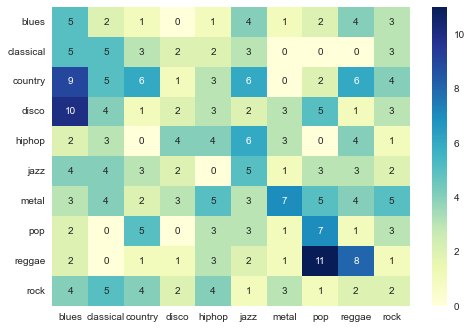

In [39]:
result_visualise(y_test, np.argmax(model2.predict(X_test), axis=-1), GENRES)

## Second Attempt

### Feature extraction
In the second attempt, instead of using frequencies as the data for model training,
the following parameters will be extracted:
1. chroma stft mean
2. chroma stft variance
3. rms mean
4. rms variance
5. spectral centroid mean
6. spectral centroid variance
7. spectral bandwidth mean
8. spectral bandwidth variance
9. spectral rolloff mean
10. spectral rolloff variance
11. zero crossing rate mean
12. zero crossing rate variance
13. tempo
14. Mel-frequency cepstral coefficients (20)

In [40]:
# Notice that the following code will use all of the CPU resource
if not os.path.exists(f'{DATA_DIR}/original_audio_features.csv'):
    def produce_df_2(path, label):
        def fetch_features(df, filename, path, label):
            y, sr = librosa.load(path)
            mfcc = librosa.feature.mfcc(y, sr)
            data = [[filename,
                    label,
                    np.mean(librosa.feature.chroma_stft(y, sr)),
                    np.var(librosa.feature.chroma_stft(y, sr)),
                    np.mean(librosa.feature.rms(y)),
                    np.var(librosa.feature.rms(y)),
                    np.mean(librosa.feature.spectral_centroid(y, sr)),
                    np.var(librosa.feature.spectral_centroid(y, sr)),
                    np.mean(librosa.feature.spectral_bandwidth(y, sr)),
                    np.var(librosa.feature.spectral_bandwidth(y, sr)),
                    np.mean(librosa.feature.spectral_rolloff(y, sr)),
                    np.var(librosa.feature.spectral_rolloff(y, sr)),
                    np.mean(librosa.feature.zero_crossing_rate(y)),
                    np.var(librosa.feature.zero_crossing_rate(y)),
                    librosa.beat.tempo(y)[0]] + [np.mean(mfcc[i]) for i in range(20)]]
            
            tmpdf = pd.DataFrame(data, columns=df.columns)
            return df.append(tmpdf, ignore_index=True)
        
        import numpy as np, pandas as pd, librosa, os
        df = pd.DataFrame(columns=['filename',
                                'label',
                                'chroma_stft_mean',
                                'chroma_stft_var',
                                'rms_mean',
                                'rms_var',
                                'spectral_centroid_mean',
                                'spectral_centroid_var',
                                'spectral_bandwidth_mean',
                                'spectral_bandwidth_var',
                                'rolloff_mean',
                                'rolloff_var',
                                'zero_crossing_rate_mean',
                                'zero_crossing_rate_var',
                                'tempo'] + [f"mfcc{i}" for i in range(1, 21)], index=None)
        for file in os.listdir(path):
            exact_path = f"{path}/{file}"
            df = fetch_features(df, file, exact_path, label)
        return df

    para = []     
    for g in GENRES:
        para.append((f"{DATA_DIR}/genres/{g}", g))

    pool = mp.Pool(mp.cpu_count()//3)
    data = pool.starmap(produce_df_2, para)

In [41]:
# store the data as csv format under DATA_DIR
if not os.path.exists(f'{DATA_DIR}/original_audio_features.csv'):
    df = pd.DataFrame(columns=data[0].columns, index=None)
    for i in range(10):
        df = df.append(data[i], ignore_index=True)
    df.to_csv(f'{DATA_DIR}/original_audio_features.csv')

### Loading back data

In [42]:
def read_fft_csv(path):
    df = pd.read_csv(path, index_col=0)
    X = df.loc[:, 'chroma_stft_mean':]
    y = df.loc[:, 'label']
    return X, y
X, y = read_fft_csv(f'{DATA_DIR}/original_audio_features.csv')

In [43]:
# replace genre name to number labelling
for idx, label in enumerate(GENRES):
    y = y.replace(label, idx)

### Classification

#### Seperate data into training set and testign set

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### 1. Logistic Regression

In [45]:
clf = LogisticRegression(max_iter=1000000).fit(X_train, y_train)

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [46]:
print(f"Accuracy on training data: {clf.score(X_train, y_train)}")
print(f"Accuracy on testing data: {clf.score(X_test, y_test)}")

Accuracy on training data: 0.4757142857142857
Accuracy on testing data: 0.44666666666666666


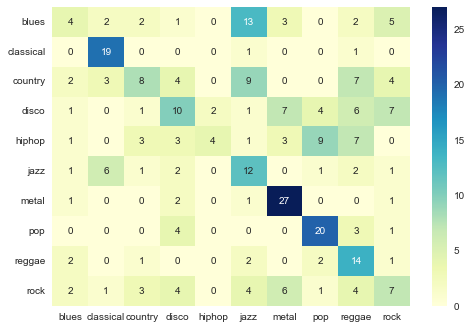

In [57]:
result_visualise(y_test, clf.predict(X_test), GENRES)

#### 2. Random Forest

In [47]:
clf = RandomForestClassifier(1000).fit(X_train, y_train)

In [48]:
print(f"Accuracy on training data: {clf.score(X_train, y_train)}")
print(f"Accuracy on training data: {clf.score(X_test, y_test)}")

Accuracy on training data: 0.9985714285714286
Accuracy on training data: 0.6866666666666666


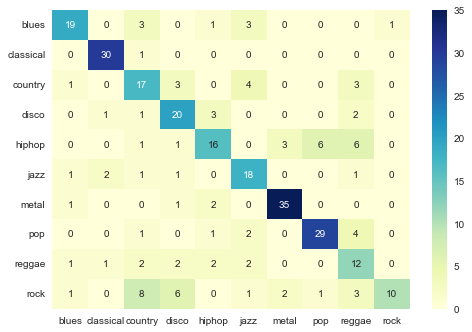

In [49]:
result_visualise(y_test, clf.predict(X_test), GENRES)

#### Scaling data to have unit norm

In [50]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [51]:
X_train = tf.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = tf.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#### 3. Simple Neural Network

In [52]:
batch_size = 16
epochs = 50

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(33,1)))

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

optimiser = tf.keras.optimizers.Adam()
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [53]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/50
44/44 [==============================] - 1s 4ms/step - loss: 1.8718 - accuracy: 0.3400
Epoch 2/50
44/44 [==============================] - 0s 4ms/step - loss: 1.2076 - accuracy: 0.5929
Epoch 3/50
44/44 [==============================] - 0s 4ms/step - loss: 0.9453 - accuracy: 0.6657
Epoch 4/50
44/44 [==============================] - 0s 4ms/step - loss: 0.7936 - accuracy: 0.7314
Epoch 5/50
44/44 [==============================] - 0s 4ms/step - loss: 0.6777 - accuracy: 0.7714
Epoch 6/50
44/44 [==============================] - 0s 4ms/step - loss: 0.6078 - accuracy: 0.7843
Epoch 7/50
44/44 [==============================] - 0s 4ms/step - loss: 0.5022 - accuracy: 0.8314
Epoch 8/50
44/44 [==============================] - 0s 4ms/step - loss: 0.4533 - accuracy: 0.8443
Epoch 9/50
44/44 [==============================] - 0s 4ms/step - loss: 0.3924 - accuracy: 0.8843
Epoch 10/50
44/44 [==============================] - 0s 3ms/step - loss: 0.3488 - accuracy: 0.8929
Epoch 11/50
44/44 [

In [54]:
model.evaluate(X_test, y_test)

10/10 [==============================] - 0s 4ms/step - loss: 1.3397 - accuracy: 0.7267


[1.3396912813186646, 0.7266666889190674]

## Third Attempt
In the third attempt, I perform FFT on the audio file and extract amplitude among frequency 0 - 11025 Hz

### Feature extraction

In [55]:
if not os.path.exists(f'{DATA_DIR}/original_fft_amp.csv'):
    def produce_df_fft(path, label):
        def get_fft(df, filename, path, label):
            y, signal = scipy.io.wavfile.read(path)
            fft_spectrum = np.fft.rfft(signal)
            freq = np.fft.rfftfreq(signal.size, d=1./y)
            fft_spectrum_abs = np.abs(fft_spectrum)
            
            data = np.column_stack((freq, np.round(fft_spectrum_abs)))
            tmpdf = pd.DataFrame(data, columns=['freq', 'amp'])
            tmpdf.loc[:, 'freq'] = np.round(tmpdf['freq'])
            
            return df.append(
                pd.DataFrame(
                    np.array(tmpdf.groupby('freq').max('amp')).reshape(1, -1),
                    columns=[str(i) for i in range(0, 11025+1)],
                ).assign(filename=filename).assign(label=label),
                ignore_index=True
            )
    
        import pandas as pd, numpy as np, scipy.io.wavfile, os
        df = pd.DataFrame(columns=['filename', 'label'] + [str(i) for i in range(0, 11025+1)], index=None)
        for file in os.listdir(path):
            exact_path = f"{path}/{file}"
            df = get_fft(df, file, exact_path, label)
        return df

    para = []     
    for g in GENRES:
        para.append((f"{DATA_DIR}/genres/{g}", g))

    pool = mp.Pool(mp.cpu_count()//2)
    data = pool.starmap(produce_df_fft, para)

In [56]:
if not os.path.exists(f'{DATA_DIR}/original_fft_amp.csv'):
    df = pd.DataFrame(columns=['filename', 'label']+[str(i) for i in range(0, 11025+1)], index=None)
    for i in range(10):
        df = df.append(data[i], ignore_index=True)
    df.to_csv(f'{DATA_DIR}/original_fft_amp.csv')
    pool.terminate()

### Loading back data

In [7]:
def read_fft_csv(path):
    df = pd.read_csv(path, index_col=0)
    X = df.loc[:, '0':]
    y = df.loc[:, 'label']
    return X, y
X, y = read_fft_csv(f'{DATA_DIR}/original_fft_amp.csv')

In [8]:
# replace genre name to number labelling
for idx, label in enumerate(GENRES):
    y = y.replace(label, idx)

### Classification

#### Seperate data into training set and testing set

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### 1. Logistic Regression

In [60]:
clf = LogisticRegression(max_iter=100000).fit(X_train, y_train)

In [61]:
print(f"Accuracy on training data: {clf.score(X_train, y_train)}")
print(f"Accuracy on testing data: {clf.score(X_test, y_test)}")

Accuracy on training data: 1.0
Accuracy on testing data: 0.54


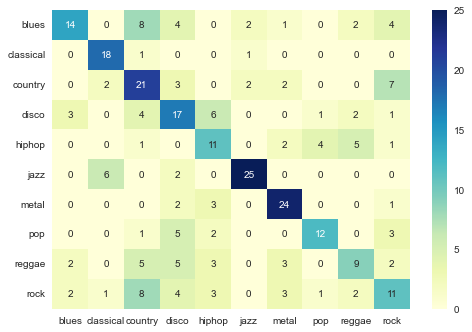

In [14]:
result_visualise(y_test, clf.predict(X_test), GENRES)

#### 2. Random Forest

In [62]:
clf = RandomForestClassifier(1000).fit(X_train, y_train)

In [63]:
print(f"Accuracy on training data: {clf.score(X_train, y_train)}")
print(f"Accuracy on testing data: {clf.score(X_test, y_test)}")

Accuracy on training data: 1.0
Accuracy on testing data: 0.5566666666666666


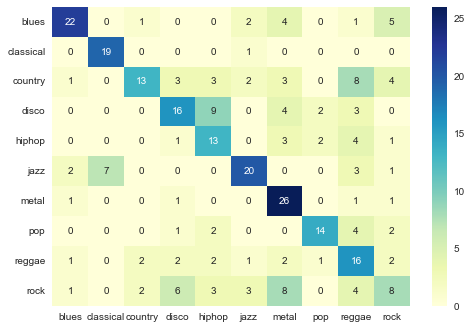

In [64]:
result_visualise(y_test, clf.predict(X_test), GENRES)

#### 3. Simple Neural Network

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_train = tf.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = tf.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [66]:
tf.random.set_seed(42)

In [67]:
batch_size = 16
epochs = 50

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(11026,1)))
model.add(tf.keras.layers.Dense(8192, activation='relu'))
model.add(tf.keras.layers.Dropout(0.05))
model.add(tf.keras.layers.Dense(4096, activation='relu'))
model.add(tf.keras.layers.Dropout(0.05))
model.add(tf.keras.layers.Dense(2048, activation='relu'))
model.add(tf.keras.layers.Dropout(0.05))
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.05))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.05))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.05))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

optimiser = tf.keras.optimizers.Adam()
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [68]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/50
44/44 [==============================] - 3s 34ms/step - loss: 9.0890 - accuracy: 0.1771
Epoch 2/50
44/44 [==============================] - 2s 34ms/step - loss: 2.0578 - accuracy: 0.2657
Epoch 3/50
44/44 [==============================] - 1s 34ms/step - loss: 1.9295 - accuracy: 0.3071
Epoch 4/50
44/44 [==============================] - 1s 34ms/step - loss: 1.8369 - accuracy: 0.3200
Epoch 5/50
44/44 [==============================] - 1s 34ms/step - loss: 1.7502 - accuracy: 0.3414
Epoch 6/50
44/44 [==============================] - 1s 34ms/step - loss: 1.6913 - accuracy: 0.3629
Epoch 7/50
44/44 [==============================] - 1s 34ms/step - loss: 1.6695 - accuracy: 0.3957
Epoch 8/50
44/44 [==============================] - 1s 34ms/step - loss: 1.6175 - accuracy: 0.4514
Epoch 9/50
44/44 [==============================] - 1s 34ms/step - loss: 1.6749 - accuracy: 0.3971
Epoch 10/50
44/44 [==============================] - 2s 34ms/step - loss: 1.5485 - accuracy: 0.4371
Epoch 11/

In [69]:
model.evaluate(X_test, y_test)

10/10 [==============================] - 0s 7ms/step - loss: 2.2669 - accuracy: 0.4833


[2.266932964324951, 0.4833333194255829]

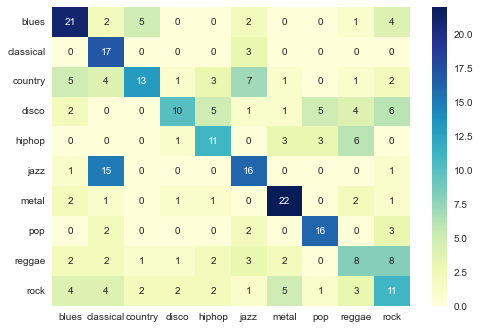

In [70]:
result_visualise(y_test, np.argmax(model.predict(X_test), axis=-1), GENRES)

In [10]:
batch_size = 16
epochs = 50

model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Conv1D(64, 2, activation='relu', input_shape=(11026,1))) # edited
model2.add(tf.keras.layers.MaxPooling1D(pool_size = 2))
model2.add(tf.keras.layers.Conv1D(128, 2, activation = 'relu'))
model2.add(tf.keras.layers.MaxPooling1D(pool_size = 2))
model2.add(tf.keras.layers.Conv1D(256, 2, activation = 'relu'))
model2.add(tf.keras.layers.MaxPooling1D(pool_size = 4))
model2.add(tf.keras.layers.Conv1D(512, 2, activation = 'relu'))
# model2.add(tf.keras.layers.MaxPooling1D(pool_size = 4))
# model2.add(tf.keras.layers.Conv1D(1024, 2, activation = 'relu'))
model2.add(tf.keras.layers.MaxPooling1D(pool_size = 4))
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dropout(0.05))
model2.add(tf.keras.layers.Dense(2048, activation = 'relu'))
model2.add(tf.keras.layers.Dropout(0.05))
model2.add(tf.keras.layers.Dense(1024, activation = 'relu'))
model2.add(tf.keras.layers.Dropout(0.05))
model2.add(tf.keras.layers.Dense(512, activation = 'relu'))
model2.add(tf.keras.layers.Dense(10, activation='softmax'))

optimiser = tf.keras.optimizers.Adam()
model2.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model2.summary()

In [11]:
model2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/50
44/44 [==============================] - 7s 83ms/step - loss: 2.3033 - accuracy: 0.1871
Epoch 2/50
44/44 [==============================] - 3s 77ms/step - loss: 1.7405 - accuracy: 0.3757
Epoch 3/50
44/44 [==============================] - 3s 77ms/step - loss: 1.6242 - accuracy: 0.4414
Epoch 4/50
44/44 [==============================] - 3s 77ms/step - loss: 1.3350 - accuracy: 0.5214
Epoch 5/50
44/44 [==============================] - 3s 78ms/step - loss: 1.0783 - accuracy: 0.6143
Epoch 6/50
44/44 [==============================] - 3s 78ms/step - loss: 0.8610 - accuracy: 0.7000
Epoch 7/50
44/44 [==============================] - 3s 77ms/step - loss: 0.6669 - accuracy: 0.7757
Epoch 8/50
44/44 [==============================] - 3s 77ms/step - loss: 0.5560 - accuracy: 0.8114
Epoch 9/50
44/44 [==============================] - 3s 77ms/step - loss: 0.3582 - accuracy: 0.8829
Epoch 10/50
44/44 [==============================] - 3s 77ms/step - loss: 0.3496 - accuracy: 0.8943
Epoch 11/

In [12]:
model2.evaluate(X_test, y_test)

10/10 [==============================] - 1s 27ms/step - loss: 2.9693 - accuracy: 0.5300


[2.9692740440368652, 0.5299999713897705]

## Fourth Attempt

### Make a larger dataset
Apply the following effects to all audio files to obtain a largest dataset:
1. Reverb / Chorus
2. Distortion
3. Pitch shift
4. Time stretch
5. Noise

In [13]:
EFFECTED_DIR = 'effected'

In [14]:
if not os.path.exists(EFFECTED_DIR):
    os.makedirs(EFFECTED_DIR)

for g in GENRES:
    if not os.path.exists(f'{EFFECTED_DIR}/{g}'):
        os.makedirs(f'{EFFECTED_DIR}/{g}')

In [15]:
# Notice that the following code will use all of the CPU resources
# i7-9750H takes around 6 hours to run
if not os.path.exists(f'{EFFECTED_DIR}/effected_fft_amp.csv'):
    def generate_audio(path, genre):
        # in python multiprocess, libraries are required to import again
        import matplotlib.pyplot as plt
        import librosa
        import librosa.display
        import soundfile as sf
        from IPython.display import Audio
        from pedalboard import Pedalboard, Convolution, Compressor, Chorus, Gain, Reverb, Limiter, LadderFilter, Phaser, NoiseGate, Distortion
        from audiomentations import Compose, AddGaussianNoise
        import os
        
        effects_1 = {"original": None,
                "reverb1": Reverb(room_size=0.25),
                #"reverb2": Reverb(room_size=0.75),
                "chorus": Chorus(),
                
                }

        effects_2 = {"original": None,
                    "distortion1": Distortion(drive_db=10),
                    "distortion2": Distortion(drive_db=-10),
                    }

        effects_3 = {"original": None,
                    "pitchshift1": 4,
                    #"pitchshift2": 8,
                    "pitchshift3": -4,
                    #"pitchshift4": 8,
                    }

        effects_4 = {"original": None,
                    "timestretch1": 0.85,
                    "timestretch2": 1.15,
                    }

        effects_5 = {"noise1": Compose([AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.005)]),
                    #"noise2": Compose([AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.05)]),
                    #"original": None
                    }
        idx = 1
        for filename in os.listdir(path):
            
            i = 1
            y, sr = librosa.load(f"{path}/{filename}")
            for n1, e1 in list(effects_1.items()):
                for n2, e2 in list(effects_2.items()):
                    for n3, e3 in list(effects_3.items()):
                        for n4, e4 in list(effects_4.items()):
                            for n5, e5 in list(effects_5.items()):
                                t = y
                                t = e1(t, sr) if e1 is not None else t 
                                t = e2(t, sr) if e2 is not None else t 
                                t = librosa.effects.pitch_shift(t, sr, n_steps=e3) if e3 is not None else t 
                                t = librosa.effects.time_stretch(t, e4) if e4 is not None else t 
                                t = e5(t, sr) if e5 is not None else t 
                                sf.write(f'effected/{genre}/{idx}-{i}-{filename[:-4]}{f"_{n1}" if e1 is not None else ""}{f"_{n2}" if e2 is not None else ""}{f"_{n3}" if e3 is not None else ""}{f"_{n4}" if e4 is not None else ""}{f"_{n5}" if e5 is not None else ""}.wav', t, sr)
                                i += 1
            idx += 1

    para = []
    for g in GENRES:
        para.append((f"{DATA_DIR}/genres/{g}", g))

    print("CPU NUMBER:", mp.cpu_count())
    pool = mp.Pool(mp.cpu_count()//2)
    pool.starmap(generate_audio, para)
    
    pool.close()
    pool.join()

### Feature extraction

In [16]:
# Notice that the following code will use all of the CPU resources
# i7-9750H takes around 2.5 hours to run
if not os.path.exists(f'{EFFECTED_DIR}/effected_fft_amp.csv'):
    def produce_df_fft(path, label):
        def get_fft(df, filename, path, label):
            y, signal = scipy.io.wavfile.read(path)
            fft_spectrum = np.fft.rfft(signal)
            freq = np.fft.rfftfreq(signal.size, d=1./y)
            fft_spectrum_abs = np.abs(fft_spectrum)
            
            data = np.column_stack((freq, np.round(fft_spectrum_abs)))
            tmpdf = pd.DataFrame(data, columns=['freq', 'amp'])
            tmpdf.loc[:, 'freq'] = np.round(tmpdf['freq'])
            
            return df.append(
                pd.DataFrame(
                    np.array(tmpdf.groupby('freq').max('amp')).reshape(1, -1),
                    columns=[str(i) for i in range(0, 11025+1)],
                ).assign(filename=filename).assign(label=label),
                ignore_index=True
            )
    
        import pandas as pd, numpy as np, scipy.io.wavfile, os
        df = pd.DataFrame(columns=['filename', 'label'] + [str(i) for i in range(0, 11025+1)], index=None)
        for file in os.listdir(path):
            exact_path = f"{path}/{file}"
            df = get_fft(df, file, exact_path, label)
        return df

    para = []     
    for g in GENRES:
        para.append((f"{EFFECTED_DIR}/{g}", g))

    pool = mp.Pool(mp.cpu_count()//2)
    data = pool.starmap(produce_df_fft, para)

In [17]:
# i7-9750H takes around 0.5 hours to run
if not os.path.exists(f'{EFFECTED_DIR}/effected_fft_amp.csv'):
    df = pd.DataFrame(columns=['filename', 'label']+[str(i) for i in range(0, 11025+1)], index=None)
    for i in range(10):
        df = df.append(data[i], ignore_index=True)
    df.to_csv(f'{EFFECTED_DIR}/effected_fft_amp.csv')
    pool.close()
    pool.join()

### Loading back data

In [18]:
# The following code will take around 10 minutes to run
def read_fft_csv(path):
    df = pd.read_csv(path, index_col=0)
    X = df.loc[:, '0':]
    y = df.loc[:, 'label']
    return X, y
X, y = read_fft_csv(f'{EFFECTED_DIR}/effected_fft_amp.csv')

In [19]:
# replace genre name to number labelling
for idx, label in enumerate(GENRES):
    y = y.replace(label, idx)

In [20]:
gc.collect()

4727

### Classification

#### Seperate data into training set and testing set

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

#### Try reducing dimension before classification

In [22]:
# Principal component analysis is used for dimensionality reduction
pca = PCA(n_components=2000)
pca.fit(X_train)

PCA(n_components=2000)

In [23]:
X_train_pca = pca.fit_transform(X_train)

In [24]:
X_train_pca = np.reshape(X_train_pca, (X_train_pca.shape[0], X_train_pca.shape[1], 1))

In [25]:
model3 = tf.keras.Sequential()

model3.add(tf.keras.layers.Flatten(input_shape=(X_train_pca.shape[1], X_train_pca.shape[2])))
model3.add(tf.keras.layers.Dense(1024, activation='relu'))
model3.add(tf.keras.layers.Dense(512, activation='relu'))
model3.add(tf.keras.layers.Dense(256, activation='relu'))
model3.add(tf.keras.layers.Dense(128, activation='relu'))
model3.add(tf.keras.layers.Dense(10, activation='softmax'))

optimiser = tf.keras.optimizers.Adam()
model3.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [26]:
model3.fit(X_train_pca, y_train, epochs=30, batch_size=64)

Epoch 1/30
886/886 [==============================] - 3s 3ms/step - loss: 260586.4688 - accuracy: 0.5738
Epoch 2/30
886/886 [==============================] - 2s 3ms/step - loss: 11201.1475 - accuracy: 0.7960
Epoch 3/30
886/886 [==============================] - 3s 3ms/step - loss: 10437.2061 - accuracy: 0.8136
Epoch 4/30
886/886 [==============================] - 2s 3ms/step - loss: 7793.9131 - accuracy: 0.8513
Epoch 5/30
886/886 [==============================] - 2s 3ms/step - loss: 8184.2476 - accuracy: 0.8395
Epoch 6/30
886/886 [==============================] - 2s 3ms/step - loss: 4929.7827 - accuracy: 0.8638
Epoch 7/30
886/886 [==============================] - 3s 3ms/step - loss: 6145.6729 - accuracy: 0.8226
Epoch 8/30
886/886 [==============================] - 3s 3ms/step - loss: 1590.8177 - accuracy: 0.7743
Epoch 9/30
886/886 [==============================] - 3s 3ms/step - loss: 355.1204 - accuracy: 0.3790
Epoch 10/30
886/886 [==============================] - 3s 3ms/step - l

In [27]:
X_test_pca = pca.fit_transform(X_test)
X_test_pca = np.reshape(X_test_pca, (X_test_pca.shape[0], X_test_pca.shape[1], 1))

model3.evaluate(X_test_pca, y_test)

760/760 [==============================] - 2s 3ms/step - loss: 2.3030 - accuracy: 0.0974


[2.3029704093933105, 0.09740740805864334]

#### Scaling data to have unit norm

In [28]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [29]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#### CNN

In [17]:
batch_size = 64
epochs = 50

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(64, 2, activation='relu', input_shape=(11026,1))) # edited
model.add(tf.keras.layers.MaxPooling1D(pool_size = 2))
model.add(tf.keras.layers.Conv1D(128, 2, activation = 'relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size = 2))
model.add(tf.keras.layers.Conv1D(256, 2, activation = 'relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size = 4))
model.add(tf.keras.layers.Conv1D(512, 2, activation = 'relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size = 4)) #
model.add(tf.keras.layers.Conv1D(1024, 2, activation = 'relu')) #
model.add(tf.keras.layers.MaxPooling1D(pool_size = 4))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.05))
model.add(tf.keras.layers.Dense(2048, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.05))
model.add(tf.keras.layers.Dense(1024, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.05))
model.add(tf.keras.layers.Dense(512, activation = 'relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

optimiser = tf.keras.optimizers.Adam()
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/50
886/886 [==============================] - 184s 198ms/step - loss: 1.4585 - accuracy: 0.4699
Epoch 2/50
886/886 [==============================] - 187s 211ms/step - loss: 0.7457 - accuracy: 0.7375
Epoch 3/50
886/886 [==============================] - 179s 202ms/step - loss: 0.4243 - accuracy: 0.8546
Epoch 4/50
886/886 [==============================] - 179s 202ms/step - loss: 0.2580 - accuracy: 0.9142
Epoch 5/50
886/886 [==============================] - 180s 204ms/step - loss: 0.1947 - accuracy: 0.9373
Epoch 6/50
886/886 [==============================] - 178s 201ms/step - loss: 0.1674 - accuracy: 0.9470
Epoch 7/50
886/886 [==============================] - 179s 202ms/step - loss: 0.1222 - accuracy: 0.9625
Epoch 8/50
886/886 [==============================] - 178s 201ms/step - loss: 0.1057 - accuracy: 0.9667
Epoch 9/50
886/886 [==============================] - 178s 201ms/step - loss: 0.0987 - accuracy: 0.9689
Epoch 10/50
886/886 [==============================] - 178s 201m

In [19]:
model.evaluate(X_test, y_test)

760/760 [==============================] - 31s 39ms/step - loss: 0.0653 - accuracy: 0.9819


[0.06530376523733139, 0.981934130191803]

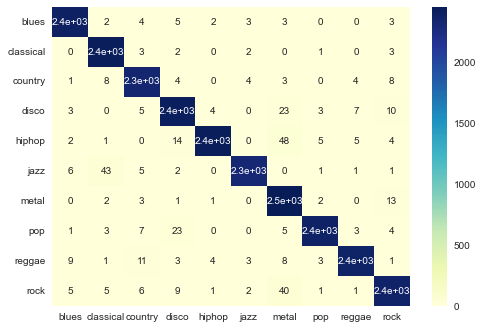

In [20]:
result_visualise(y_test, np.argmax(model.predict(X_test), axis=-1), GENRES)

#### Convert the Tensorflow lite model

In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open('model2.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\YEEKII~1\AppData\Local\Temp\tmp0h52dfu5\assets
